In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt

from ssm.models import HMM, SLDS, LDS
from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [3]:
K = 8
D = 6

# Dimensionality reduction on $\Delta$F/F 

In [4]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)
xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
# dxs = [gaussian_filter1d(np.gradient(x, axis=0), 1, axis=0) for x in xs]

lim = 1.1 * abs(np.vstack(xs)).max()

Text(0.5,0.98,'Continuous Latent States (Zimmer Labels)')

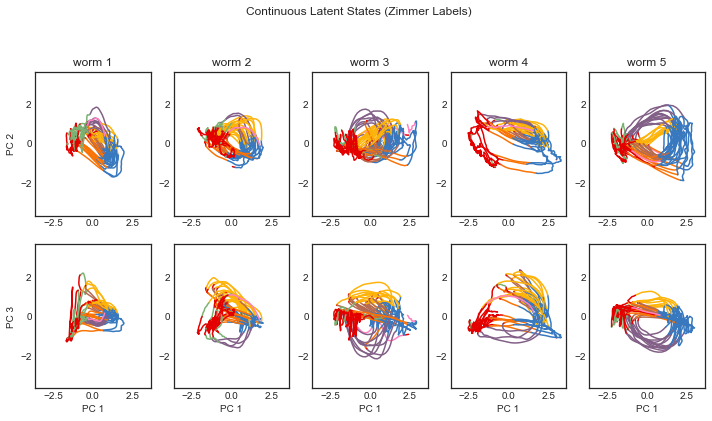

In [5]:
plt.figure(figsize=(12, 9))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    ax = plt.subplot(3, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.title("worm {}".format(w+1))

    ax = plt.subplot(3, W, W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")
    
    ax = plt.subplot(3, W, 2 * W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")
    
plt.suptitle("Continuous Latent States (Zimmer Labels)")

In [6]:
# Dxs = np.concatenate(dxs)
# Dxs = (Dxs - Dxs.mean(0)) / (Dxs.std(0))
# dxs = np.split(Dxs, np.cumsum(Ts[:-1]))

In [7]:
# plt.figure(figsize=(12, 9))
# for w, (x, z) in enumerate(zip(dxs, z_trues)):
#     ax = plt.subplot(3, W, w+1)
#     zplt.plot_2d_continuous_states(x, z, xlims=(-4.5, 4.5), ylims=(-4.5, 4.5), inds=(0, 1), ax=ax)
#     plt.ylabel("PC 2" if w == 0 else "")
#     plt.title("worm {}".format(w+1))

#     ax = plt.subplot(3, W, W+w+1)
#     zplt.plot_2d_continuous_states(x, z, xlims=(-4.5, 4.5), ylims=(-4.5, 4.5), inds=(0, 2), ax=ax)
#     plt.ylabel("PC 3" if w == 0 else "")
#     plt.xlabel("PC 1")
    
#     ax = plt.subplot(3, W, 2 * W+w+1)
#     zplt.plot_2d_continuous_states(x, z, xlims=(-4.5, 4.5), ylims=(-4.5, 4.5), inds=(0, 3), ax=ax)
#     plt.ylabel("PC 4" if w == 0 else "")
#     plt.xlabel("PC 1")    
# plt.suptitle("Continuous Latent States (Zimmer Labels)")

In [8]:
# # HACK
# xs = dxs

# Fit an ARHMM to the continuous latent states

In [9]:
hmm = HMM(K, D, M=0, 
          transitions="standard", 
          observations="ar", 
          # hierarchical_observation_tags=list(range(W))
         )

In [10]:
lls = hmm.fit(xs, method="em", num_em_iters=50, tags=list(range(W)))

Iteration 0.  LL: 207294.4
Iteration 1.  LL: 218910.2
Iteration 2.  LL: 222012.0
Iteration 3.  LL: 223487.7
Iteration 4.  LL: 224591.2
Iteration 5.  LL: 225176.7
Iteration 6.  LL: 225505.6
Iteration 7.  LL: 225731.8
Iteration 8.  LL: 225927.6
Iteration 9.  LL: 226094.6
Iteration 10.  LL: 226269.4
Iteration 11.  LL: 226410.9
Iteration 12.  LL: 226525.4
Iteration 13.  LL: 226610.9
Iteration 14.  LL: 226685.2
Iteration 15.  LL: 226756.5
Iteration 16.  LL: 226802.9
Iteration 17.  LL: 226746.9
Iteration 18.  LL: 226604.4
Iteration 19.  LL: 226506.4
Iteration 20.  LL: 226450.9
Iteration 21.  LL: 226411.9
Iteration 22.  LL: 226382.3
Iteration 23.  LL: 226340.7
Iteration 24.  LL: 226308.5
Iteration 25.  LL: 226296.7
Iteration 26.  LL: 226292.1
Iteration 27.  LL: 226278.9
Iteration 28.  LL: 226262.2
Iteration 29.  LL: 226247.3
Iteration 30.  LL: 226240.1
Iteration 31.  LL: 226242.0
Iteration 32.  LL: 226274.2
Iteration 33.  LL: 226319.6
Iteration 34.  LL: 226332.2
Iteration 35.  LL: 226336.9
It

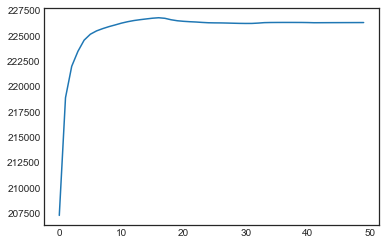

In [11]:
plt.plot(lls)

In [12]:
z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

In [13]:
np.bincount(np.concatenate(z_infs), minlength=8)

array([1853, 3579, 1198, 2568, 1429, 1500, 1898, 2171])

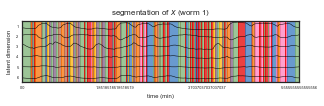

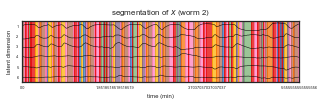

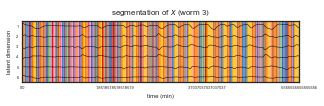

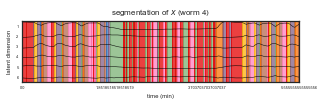

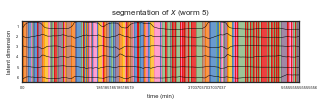

In [14]:
zplt.plot_latent_trajectories_vs_time(xs, z_infs, plot_slice=(0, 1000))

Text(0.5,0.98,'Continuous Latent States (Zimmer Labels)')

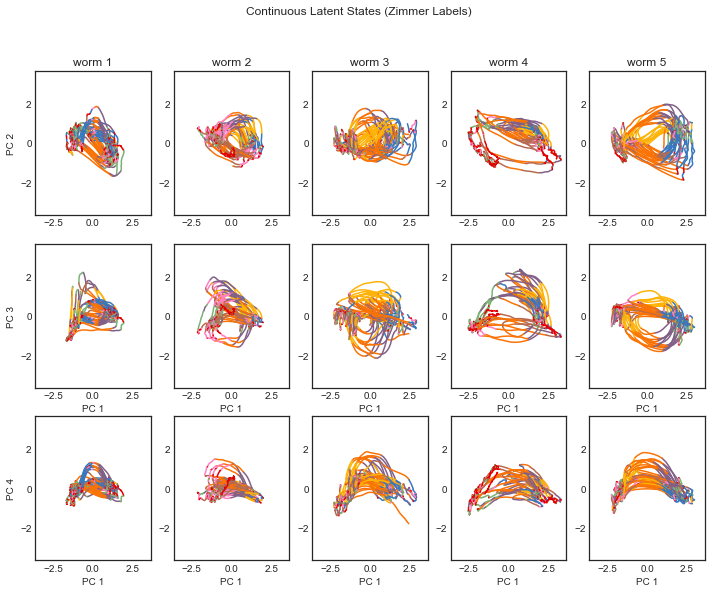

In [15]:
plt.figure(figsize=(12, 9))
for w, (x, z) in enumerate(zip(xs, z_infs)):
    ax = plt.subplot(3, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.title("worm {}".format(w+1))

    ax = plt.subplot(3, W, W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")
    
    ax = plt.subplot(3, W, 2 * W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
    plt.ylabel("PC 4" if w == 0 else "")
    plt.xlabel("PC 1")    
plt.suptitle("Continuous Latent States (Zimmer Labels)")

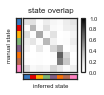

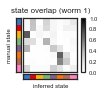

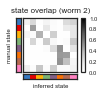

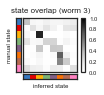

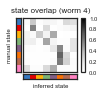

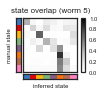

In [16]:
zplt.plot_state_overlap(z_infs, z_trues)

In [17]:
np.linalg.eigvals(hmm.observations.As).round(2)

array([[1.01+0.04j, 1.01-0.04j, 0.96+0.j  , 0.99+0.02j, 0.99-0.02j,
        1.01+0.j  ],
       [0.99+0.j  , 0.99-0.j  , 1.  +0.j  , 1.  -0.j  , 1.  +0.j  ,
        1.  -0.j  ],
       [0.97+0.09j, 0.97-0.09j, 0.91+0.j  , 0.99+0.j  , 1.03+0.01j,
        1.03-0.01j],
       [1.02+0.j  , 0.99+0.01j, 0.99-0.01j, 1.01+0.j  , 1.  +0.j  ,
        1.  -0.j  ],
       [1.12+0.j  , 0.98+0.j  , 1.02+0.02j, 1.02-0.02j, 1.  +0.01j,
        1.  -0.01j],
       [1.  +0.07j, 1.  -0.07j, 0.93+0.j  , 0.97+0.01j, 0.97-0.01j,
        0.95+0.j  ],
       [0.91+0.j  , 1.01+0.04j, 1.01-0.04j, 1.  +0.j  , 0.98+0.j  ,
        0.96+0.j  ],
       [1.01+0.j  , 1.  +0.j  , 1.  -0.j  , 0.98+0.01j, 0.98-0.01j,
        0.98+0.j  ]])

# Simulate from an HMM, reducing the dynamics noise

In [18]:
hmm_low_noise = copy.deepcopy(hmm)
hmm_low_noise.observations.inv_sigmas -= 2

In [19]:
pad = 3
Tsmpl = Ts[0]
i = 1
zpre, xpre = z_infs[i][-pad:], xs[i][-pad:]
zsmpl, xsmpl = hmm_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=i, with_noise=True)

zfull = np.concatenate((zpre, zsmpl))
xfull = np.concatenate((xpre, xsmpl))

Text(0,0.5,'PC 3')

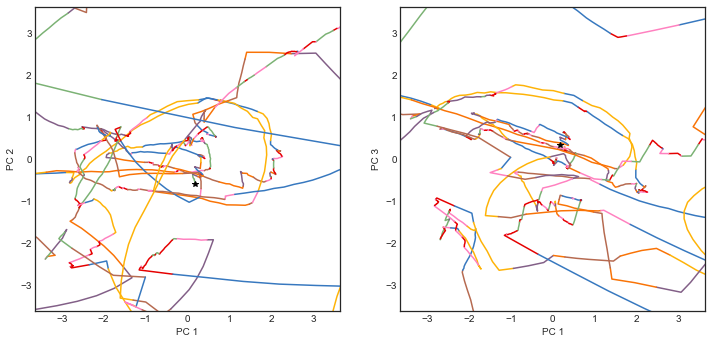

In [20]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1, aspect="equal")
zplt.plot_2d_continuous_states(xfull, zfull, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
plt.plot(xfull[pad-1,0], xfull[pad-1,1], 'k*')
plt.xlabel("PC 1")
plt.ylabel("PC 2")

ax = plt.subplot(1, 2, 2, aspect="equal")
zplt.plot_2d_continuous_states(xfull, zfull, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
plt.plot(xfull[pad-1,0], xfull[pad-1,2], 'k*')
plt.xlabel("PC 1")
plt.ylabel("PC 3")

Text(0.5,0,'time (s)')

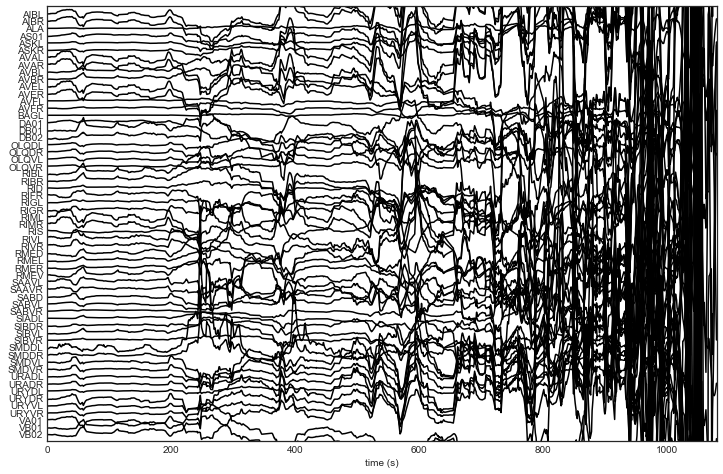

In [21]:
plt.figure(figsize=(12, 8))
ysim = xfull.dot(pca.components_) + pca.mean_
plt.plot(np.arange(ysim.shape[0]) / 3.0, ysim - np.arange(N), '-k')
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, ysim.shape[0] / 3.0)
plt.xlabel("time (s)")

Text(0.5,0,'time (s)')

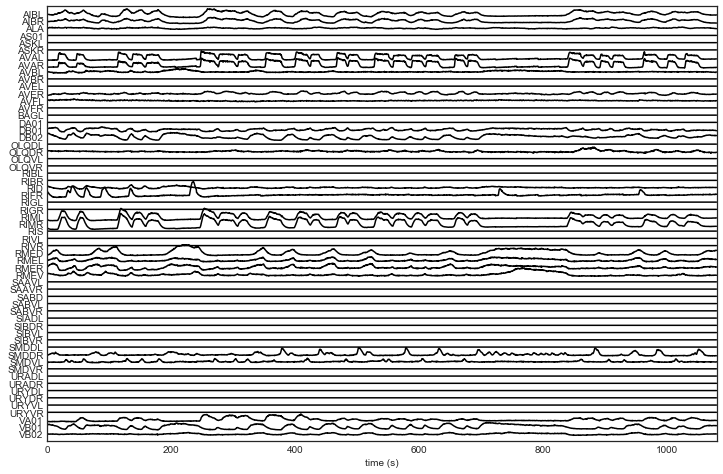

In [22]:
# Plot real data for comparison
plt.figure(figsize=(12, 8))
plt.plot(np.arange(Ts[0]) / 3.0, ys[0] - np.arange(N), '-k')
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, Ts[0] / 3.0)
plt.xlabel("time (s)")